# 6장 텍스트와 시퀀스를 위한 딥러닝

## 6-1 텍스트 데이터 다루기

### 6-1-1 단어와 문자의 원-핫 인코딩

In [ ]:
import numpy as np

samples = ['The cat sat on the mat.' , 'The dog ate my homework.']

token_index = {}

for sample in samples:
    for word in sample.split():

        if word not in token_index:
            token_index[word] = len( token_index ) + 1

max_length = 10

results = np.zeros(shape=(len(samples) ,
                          max_length ,
                          max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j , word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i , j , index] = 1.

In [ ]:
import string

sample =  ['The cat sat on the mat.' , 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters , range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples) ,max_length , max(token_index.values()) + 1 ))

for i, sample in enumerate(samples):
    for j , character in enumerate(sample):
        index = token_index.get(character)
        results[i , j , index] = 1.

In [ ]:
results.shape

(2, 50, 101)

In [ ]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.' , 'The dog ate my homework.']

tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples) # 문자열을 정수 인덱스의 리스트로 변환합니다.

one_hot_results = tokenizer.texts_to_matrix(samples ,mode = 'binary')

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

9개의 고유한 토큰을 찾았습니다.


In [ ]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [ ]:
one_hot_results.shape

(2, 1000)

In [ ]:
samples = ['The cat sat on the mat.' , 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples) , max_length , dimensionality))

for i, sample in enumerate(samples):
    for j,word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i , j , index] = 1

In [ ]:
results.shape

(2, 10, 1000)

### 6-1-2 단어 임베딩 사용하기

#### Embedding 층을 사용하여 단어 임베딩 학습하기

In [1]:
from keras.layers import Embedding

embedding_layer = Embedding(1000 , 64)

In [2]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train , y_train) , (x_test , y_test) = imdb.load_data(num_words = max_features)

x_train = preprocessing.sequence.pad_sequences(x_train , maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test , maxlen=maxlen)
#pad_sequences ===> 리스트를 (samples , maxlen)크기의 2D 정수 텐서로 변환합니다.

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense , Embedding

model = Sequential()
model.add(Embedding(10000 , 8 , input_length=maxlen))

model.add(Flatten())

model.add(Dense(1 , activation = 'sigmoid'))
model.compile(optimizer='rmsprop' , loss = 'binary_crossentropy' , metrics=['acc']) 
model.summary()

history = model.fit(x_train , y_train , epochs = 10 , batch_size = 32 , validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6554 - acc: 0.6425 - val_loss: 0.5935 - val_acc: 0.7054
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5222 - acc: 0.7570 - val_loss: 0.5160 - val_acc: 0.7330
Epoch 3/10
625/625 [==============================] 

#### 사전 훈련된 단어 임베딩 사용하기

### 6-1-3 모든 내용을 적용하기: 원본 텍스트에서 단어 임베딩까지

In [ ]:
import os
imdb_dir = '/content/drive/MyDrive/AI/독학/케라스 창시자/aclImdb/aclImdb/test'
train_dir = os.path.join(imdb_dir  , 'train')

labels = []

texts = []

for label_type in ['neg' , 'pos']:
    dir_name =os.path.join(train_dir , label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(train_dir , label_type))

임베딩 파트는 데이터 문제로 일단은 스킵

## 6-2 순환 신경망 이해하기

In [9]:
# 넘파이로 구현한 간단한 RNN

import numpy as np
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps , input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features , input_features))
U = np.random.random((output_features , output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W , input_t) + np.dot(U , state_t) + b)

    successive_outputs.append(output_t)

    state_t = output_t

final_output_sequence = np.stack(successive_outputs , axis = 0)

### 6-2-1 케라스의 순환 층

In [1]:
from keras.layers import SimpleRNN

In [2]:
from keras.models import Sequential
from keras.layers import Embedding , SimpleRNN
model = Sequential()
model.add(Embedding(10000 , 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = Sequential()
model.add(Embedding(10000 , 32))
model.add(SimpleRNN(32 , return_sequences = True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000 , 32))
model.add(SimpleRNN(32 , return_sequences=True))
model.add(SimpleRNN(32 , return_sequences=True))
model.add(SimpleRNN(32 , return_sequences=True))
model.add(SimpleRNN((32)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [5]:
#IMDB 데이터 전처리 하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('데이터 로딩...')
(input_train , y_train) , (input_test , y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train) , '훈련 시퀀스')
print(len(input_test) , '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')

input_train = sequence.pad_sequences(input_train , maxlen = maxlen)
input_test = sequence.pad_sequences(input_test , maxlen=maxlen)
print('input_train 크기:' , input_train.shape )
print('input_test:' , input_test.shape)

데이터 로딩...
17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test: (25000, 500)


In [6]:
# Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features , 32))
model.add(SimpleRNN(32))
model.add(Dense(1 , activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop' , loss='binary_crossentropy' , metrics = ['acc'])
history = model.fit(input_train , y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 38s 230ms/step - loss: 0.6354 - acc: 0.6239 - val_loss: 0.5684 - val_acc: 0.7174
Epoch 2/10
157/157 [==============================] - 41s 264ms/step - loss: 0.4221 - acc: 0.8202 - val_loss: 0.4364 - val_acc: 0.8108
Epoch 3/10
157/157 [==============================] - 51s 326ms/step - loss: 0.3002 - acc: 0.8783 - val_loss: 0.4555 - val_acc: 0.7888
Epoch 4/10
157/157 [==============================] - 55s 351ms/step - loss: 0.2257 - acc: 0.9150 - val_loss: 0.3690 - val_acc: 0.8598
Epoch 5/10
157/157 [==============================] - 49s 314ms/step - loss: 0.1671 - acc: 0.9398 - val_loss: 0.5493 - val_acc: 0.8154
Epoch 6/10
157/157 [==============================] - 35s 225ms/step - loss: 0.1072 - acc: 0.9631 - val_loss: 0.5826 - val_acc: 0.7504
Epoch 7/10
157/157 [==============================] - 31s 198ms/step - loss: 0.0705 - acc: 0.9779 - val_loss: 0.4861 - val_acc: 0.8226
Epoch 8/10
157/157 [==============================] - 3

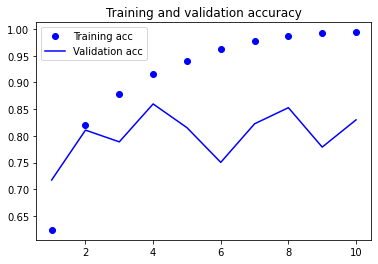

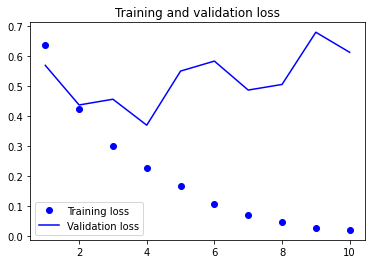

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs ,acc , 'bo' , label='Training acc')
plt.plot(epochs , val_acc , 'b' , label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs , loss , 'bo' , label = 'Training loss')
plt.plot(epochs , val_loss , 'b' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6-2-2 LSTM과 GRU 층 이해하기

In [ ]:
# LSTM 구조의 의사코드 (1/2)
output_t = activation(c_t) * activation(dot(input_t , Wo) + dot(state_t , Uo) + bo)

i_t = activation(dot(state_t , Ui) + dot(input_t , Wi) + bi)
f_t = activation(dot(state_t , Uf) + dot(input_t , Wf) + bf)
k_t = activation(dot(state_t , Uk) + dot(input_t , Wk) + bk)

In [ ]:
# LSTM 구조의 의사코드(2/2)
(c_t + 1) = i_t * k_t + c_t * f_t

### 6-2-3 케라스를 사용한 LSTM 예제

## 6-3 순환 신경망의 고급 사용법

In [10]:
%cd /content/drive/MyDrive/AI/독학/케라스 창시자

/content/drive/MyDrive/AI/독학/케라스 창시자


In [11]:
mkdir jena_climate

In [12]:
%cd jena_climate

/content/drive/MyDrive/AI/독학/케라스 창시자/jena_climate


In [30]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-03-20 08:01:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.72MB/s    in 2.3s    

2022-03-20 08:01:07 (5.72 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [31]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [1]:
import os

data_dir = '/content/drive/MyDrive/AI/독학/케라스 창시자/jena_climate'
fname = os.path.join(data_dir , 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

float_data = np.zeros((len(lines) , len(header) - 1))
for i , line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

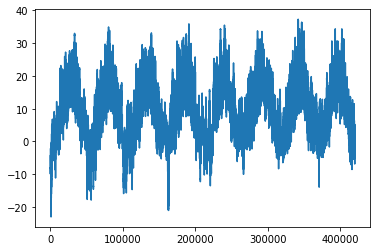

In [3]:
from matplotlib import pyplot as plt

temp = float_data[: , 1]
plt.plot(range(len(temp)) , temp)

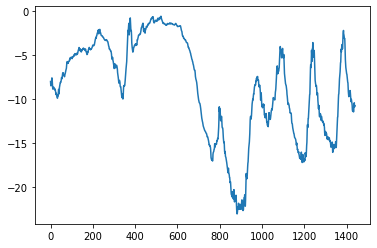

In [4]:
plt.plot(range(1440) , temp[:1440])

### 6-3-2 데이터 준비

In [5]:
# 데이터 정규화 하기
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data , lookback , delay , min_index , max_index , shuffle=False , batch_size = 128 , step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1

    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint( min_index + lookback , max_index , size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i , min( i + batch_size , max_index))
            i += len(rows)
        samples = np.zeros((len(rows),          # 데이터 수
                            lookback // step,   # 각 시간
                            data.shape[-1]))    # 각 시간 당 데이터 피처 수

        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range( rows[j] - lookback , rows[j] , step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples , targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle=True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6-3-3 상식 수준의 기준점

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[: , -1 , 1]
        mae = np.mean(np.abs(preds - targets))
    print(np.mean(batch_maes))

evaluate_naive_method()

nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


### 6-3-4 기본적인 머신 러닝

In [15]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step , float_data.shape[-1])))
model.add(layers.Dense(32 , activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop() , loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
500/500 [==============================] - 19s 36ms/step - loss: 0.9499 - val_loss: 0.3791
Epoch 2/20
500/500 [==============================] - 19s 39ms/step - loss: 0.3437 - val_loss: 0.3433
Epoch 3/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2814 - val_loss: 0.3173
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2617 - val_loss: 0.3117
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2516 - val_loss: 0.3145
Epoch 6/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2446 - val_loss: 0.3431
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2386 - val_loss: 0.3352
Epoch 8/20
500/500 [==============================] - 20s 41ms/step - loss: 0.2345 - val_loss: 0.3560
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2304 - val_loss: 0.3258
Epoch 10/20
500/500 [==============================] - 20s 40ms/step - loss: 0.227

In [16]:
import matplotlib.pyplot as plot
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(loss) + 1)

plt.figure()
plt.plot(epochs , loss , 'bo' , label = 'Training loss')
plt.plot(epochs , val_loss , 'b' , label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 6-3-5 첫 번째 순환 신경망

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2

model = Sequential()
model.add(layers.GRU(32 , input_shape = (None , float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop() , loss = 'mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 20,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 90s 175ms/step - loss: 0.3019 - val_loss: 0.2689
Epoch 2/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2831 - val_loss: 0.2701
Epoch 3/20
500/500 [==============================] - 90s 181ms/step - loss: 0.2758 - val_loss: 0.2654
Epoch 4/20
500/500 [==============================] - 90s 181ms/step - loss: 0.2717 - val_loss: 0.2644
Epoch 5/20
500/500 [==============================] - 88s 175ms/step - loss: 0.2673 - val_loss: 0.2705
Epoch 6/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2613 - val_loss: 0.2669
Epoch 7/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2588 - val_loss: 0.2645
Epoch 8/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2532 - val_loss: 0.2734
Epoch 9/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2482 - val_loss: 0.2700
Epoch 10/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2443

### 6-3-7 스태킹 순환 층

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences = True,
                     input_shape = (None , float_data.shape[-1])))
model.add(layers.GRU(64 , activation='relu',
                     dropout = 0.1  ,recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop() , loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 486s 961ms/step - loss: 0.3197 - val_loss: 0.2816
Epoch 2/40
500/500 [==============================] - 513s 1s/step - loss: 0.3008 - val_loss: 0.2781
Epoch 3/40
500/500 [==============================] - 418s 836ms/step - loss: 0.2940 - val_loss: 0.2737
Epoch 4/40
500/500 [==============================] - 416s 833ms/step - loss: 0.2883 - val_loss: 0.2672
Epoch 5/40
500/500 [==============================] - 418s 837ms/step - loss: 0.2803 - val_loss: 0.2700
Epoch 6/40
500/500 [==============================] - 434s 868ms/step - loss: 0.2754 - val_loss: 0.2702
Epoch 7/40
500/500 [==============================] - 568s 1s/step - loss: 0.2715 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 529s 1s/step - loss: 0.2653 - val_loss: 0.2736
Epoch 9/40
500/500 [==============================] - 540s 1s/step - loss: 0.2587 - val_loss: 0.2801
Epoch 10/40
500/500 [==============================] - 455s 910ms/step - loss: 0.2549 -

### 6-3-8 양방향 RNN 사용하기

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import sequential

max_features = 10000
maxlen = 500

(x_train , y_train),(x_test , y_test) = imdb.load_data(num_words = max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train , maxlen=maxlen)
x_test = sequence.pad_sequences(x_test , maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features , 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1 , activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(x_train , y_train,
                    epochs=10,
                    batch_size = 128,
                    validation_split = 0.2)

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1 , activation='sigmoid'))

model.compile(optimizer='rmsprop' , loss = 'binary_crossentropy' , metrics=['acc'])
history = model.fit(x_train , y_train ,
                    epochs = 10 , batch_size = 128,
                    validation_split=0.2)

In [ ]:
# 규제를 더 추가해 보자~
from keras.models import Sequential
from keras import layers
from keras.optimizers import PMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None , float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop() , loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs=40,
                              validation_data = val_gen,
                              validation_steps = val_steps
                              )

### 6-3-9 더 나아가서

### 6-3-10 정리

## 6-4 컨브넷을 사용한 시퀀스 처리

### 6-4-1 시퀀스 데이터를 위한 1D 합성곱 이해하기

### 6-4-2 시퀀스 데이터를 위한 1D 풀링

In [ ]:
# IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('데이터 로드...')
(x_train , y_train), (x_test , y_test) = imdb.load_data(num_words=max_features)
print(len(x_train) , '훈련 시퀀스')
print(len(x_test) , '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train , sequence.pad_sequences(x_train , maxlen=max_len)
x_test = sequence.pad_sepuences(x_test , maxlen=max_len)
print('x_train 크기:' , x_train.shape)
print('x_test 크기:' , x_test.shape)

In [ ]:
from keras.models import sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embbeding(max_features, 128 , input_length=max_len))
model.add(layers.Conv1D(32 , 7 , activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32 , 7  ,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train , y_train , epochs=10 , batch_size = 128, validation_split=0.2)

### 6-4-4 CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32 , 5 , activation = 'relu' , input_shape=(None , float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32 ,5 , activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop() , loss = 'mae')
history = model.fit_generator(train_gen , 
                              steps_per_epoch = 500,
                              validation_data = val_gen,
                              validation_steps=val_steps)

In [ ]:
step = 3
lookback = 1440
delay = 144

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay, 
                      min_index = 0,
                      max_index = 200000,
                      shuffle=True,
                      step = step)
val_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay, 
                      min_index = 200001,
                      max_index = 300000,
                      shuffle=True,
                      step = step)
test_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay, 
                      min_index = 300001,
                      max_index = None,
                      shuffle=True,
                      step = step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32 , 5 , activation='relu' , input_shape = (None , float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.GRU(32 , dropout=0.1 , recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop() , loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps
                              )

### 6-4-5 정리